
<a id='chap-tpreseauxneuronesmulticouches1'></a>

# Réseaux de neurones multicouches (1). Les iris

Le but de cette séance de TP est d’illustrer le fonctionnement des perceptrons multi-couches pour un problème de classification et d’explorer l’impact des fonctions d’activation des neurones de la couche cachée, du nombre de neurones cachés et du nombre de couches cachées.

## Préparation des données

On essaie une fois de plus de classifier les  [fleurs d’iris](https://archive.ics.uci.edu/ml/datasets/iris).  L’objectif est (toujours...) de prédire la variété à partir des quatre variables explicatives (longueurs et largeurs des sépales et des pétales).

In [1]:
import sklearn
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# On importe et on structure les données
iris = datasets.load_iris()
iris.keys()
X = iris.data  
Y = iris.target
# Ici, on n'a pas de structuration particulière, on conserve le jeu de données tel qu'il est sans modifier 
# les caractéristiques ni les étiquettes

## Perceptrons multi-couches (PMC) dans Scikit-learn

Dans Scikit-learn, les PMC sont implémentés dans les classes [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) pour la classification et [MPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) pour la régression. Nous examinons dans la suite l’utilisation des PMC pour traiter des problèmes de classification.

Les paramètres de [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) permettent de définir l’architecture du PMC (nombre de couches et de neurones dans chaque couche), les fonctions d’activation pour les couches cachées, et d'autres paramètres que nous n'étudierons pas ici (en particulier la méthode d’optimisation. Nous conserverons donc la méthode d’optimisation par défaut qui est SGD, la descente de gradient stochastique).  Vous pouvez examiner [les valeurs par défaut des autres paramètres](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

### Ensembles d’apprentissage et de test

Séparons d’abord l’enseble des observations disponibles en données d’apprentissage et données de test. Pour pouvoir répéter les expérimentations, il est utile d’initialiser explicitement le générateur pseudo-aléatoire avec `np.random.seed(...)`. La fonction `train_test_split` sépare les données en deux ensembles distincts, *train* et *test*, suivant la proportion de données de *test* indiquée avec `test_size` ; la séparation est réalisée par échantillonnage aléatoire uniforme.

In [3]:
# 2) à l'aide de train_test_split, partager les données en un jeu d'apprentissage (80%) et un jeu de test (20%)
# 
from sklearn.model_selection import train_test_split
Xa, Xt, Ya, Yt = train_test_split(X,Y,test_size=0.4)
print(X[:5,2:4])

[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]]


### Construction d’un modèle pour illustration

Afin de pouvoir visualiser la frontière nonlinéaire de séparation entre classes, nous construisons d’abord un modèle avec des valeurs par défaut pour tous les hyper-paramètres sauf pour le nombre maximum d’itérations (la valeur par défaut de 200 étant insuffisante).  

In [4]:
from sklearn.neural_network import MLPClassifier
# donner une valeur à random_state rend possible la répétabilité
clf = MLPClassifier(max_iter=1000,random_state=0)
# apprentissage avec les deux dernières variables
clf.fit(Xa[:,2:4], Ya)

MLPClassifier(max_iter=1000, random_state=0)

Les taux de bon classement en apprentissage (*train*) et en test sont :

In [5]:
train_score = clf.score(Xa[:,2:4], Ya)
print("Le score sur les données d'apprentissage est {}".format(train_score))
test_score = clf.score(Xt[:,2:4], Yt)
print("Le score sur les données de test est {}".format(test_score))

Le score sur les données d'apprentissage est 0.9666666666666667
Le score sur les données de test est 0.95


Nous affichons les résultats : observations d’apprentissage (points pleins), observations de test (points creux), frontière de séparation. Pour déterminer la frontière de séparation, nous définissons dans le domaine de variation des deux variables explicatives une grille dense, calculons les prédictions du modèle sur tous les points de la grille et affichons un contour qui correspond aux points du plan où l’indétermination est maximale.

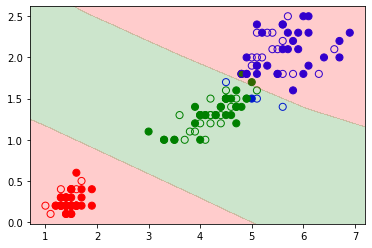

In [22]:
# créer une nouvelle figure
plt.figure()
# afficher les nuages de points d'apprentissage (pleins) et de test (creux)
# suivant la classe, les points affichés sont rouges ou verts 
cmp = np.array(['r','g','b'])
plt.scatter(Xa[:,2],Xa[:,3],c=cmp[Ya],s=50)
plt.scatter(Xt[:,2],Xt[:,3],c='none',s=50,edgecolors=cmp[Yt])
# calculer la probabilité de sortie du MLP pour tous les points du plan
nx, ny = 200, 200
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min,x_max, nx),np.linspace(y_min,y_max, ny))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z1 = Z[:, 1].reshape(xx.shape)
# dessiner le contour correspondant à la frontière proba = 0,5
cs=plt.contourf(xx, yy, Z1, [0,0.5,1],colors=['red','green','blue'],alpha=0.2)

plt.show()

  
Nous avons employé la fonction `predict_proba` afin d’obtenir, pour chaque point de la grille, la prédiction du réseau sous la forme de probabilité. Le réseau a deux neurones de sortie, un donne la probabilité d’appartenance à la classe Versicolor et l’autre neurone la probabilité d’appartenance à l’autre classe. 

Il est également possible de visualiser l’évolution de l’erreur d’apprentissage au fil des itérations car les valeurs sont conservées dans l’attribut loss_curve_ du modèle obtenu :

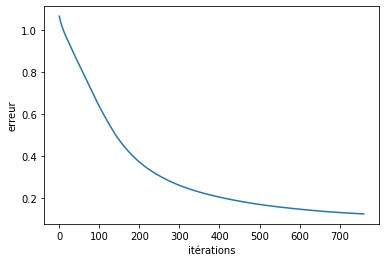

In [57]:
plt.figure()
plt.xlabel('itérations')
plt.ylabel('erreur')
plt.plot(clf.loss_curve_)
plt.show()


On constate qu’après 1000 itérations la pente de la courbe n’est pas nulle, il est donc possible de diminuer encore l’erreur d’apprentissage en augmentant le nombre d’itérations.

## Jouons avec les hyperparamètres : 
## fonctions d’activation, nombre de couches, nombre de neurones par couche

Pour mieux comprendre l’utilisation des différentes fonctions d’activations proposées pour les neurones des couches cachées, faites des essais avec toutes les fonctions proposées, `identity`, `logistic`, `tanh`, `relu` (déjà employée ci-dessus), en conservant les autres paramètres (sauf `max_iter=1000`) aux valeurs par défaut.

Le score sur les données d'apprentissage avec identity est 0.9555555555555556
Le score sur les données de test avec identity est 0.9833333333333333
Le score sur les données d'apprentissage avec logistic est 0.9444444444444444
Le score sur les données de test avec logistic est 0.9833333333333333
Le score sur les données d'apprentissage avec tanh est 0.9444444444444444
Le score sur les données de test avec tanh est 0.9666666666666667
Le score sur les données d'apprentissage avec relu est 0.9444444444444444
Le score sur les données de test avec relu est 0.9666666666666667


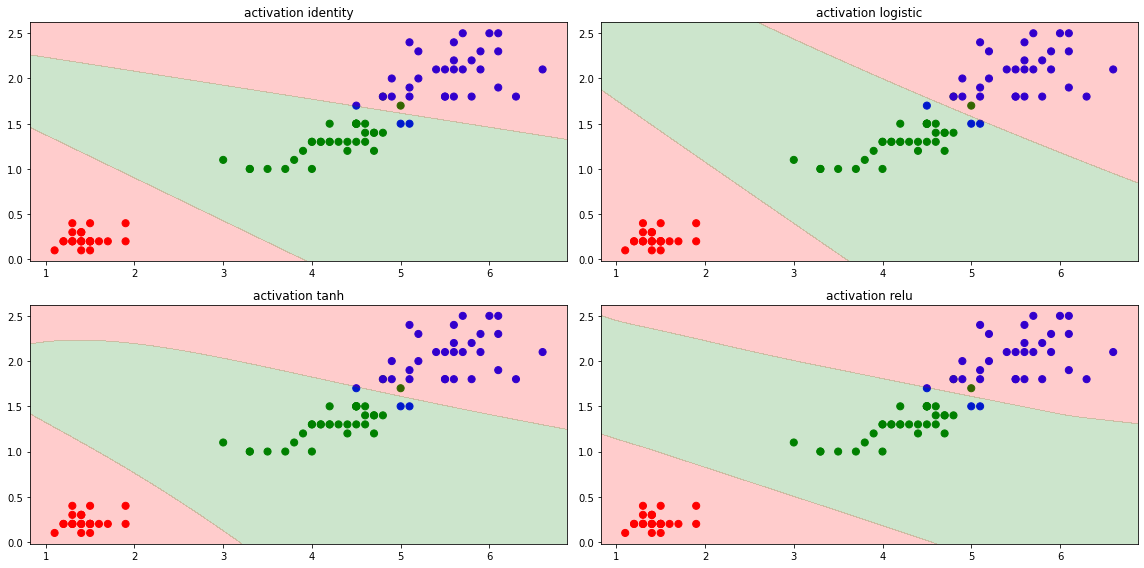

In [26]:
activations=['identity','logistic','tanh','relu']
I=[(0,0),(0,1),(1,0),(1,1)]
Xa, Xt, Ya, Yt = train_test_split(X,Y,test_size=0.4)
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(16)

for a,(i,j) in zip(activations,I):
    clf= MLPClassifier(max_iter=2000,activation=a, random_state=0)
    clf.fit(Xa[:,2:4], Ya)
    train_score = clf.score(Xa[:,2:4], Ya)
    print("Le score sur les données d'apprentissage avec {} est {}".format(a,train_score))
    test_score = clf.score(Xt[:,2:4], Yt)
    print("Le score sur les données de test avec {} est {}".format(a,test_score))
    axs[i,j].scatter(Xa[:,2],Xa[:,3],c=cmp[Ya],s=50)
    axs[i,j].set_title(f'activation {a}')
    #frontiere   
    nx, ny = 200, 200
    x_min, x_max = axs[i,j].get_xlim()
    y_min, y_max = axs[i,j].get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min,x_max, nx),np.linspace(y_min,y_max, ny))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z1 = Z[:, 1].reshape(xx.shape)
    axs[i,j].contourf(xx, yy, Z1, [0,0.5,1],colors=['red','green','blue'],alpha=0.2)
       
    
    
fig.tight_layout()

    
    

## Question :

Que constatez-vous ? Pourquoi les performances obtenues avec `identity` sont nettement inférieures ? Il est utile pour cela de regarder quelle frontière de séparation est trouvée.

## Réponse :



<div class="alert alert-block alert-success">
L'activation identity permet de classifier selon deux droites, pour les iris , cela reste encore raisonable. Mais pour beaucoups de classifications, le modèle restera innéficace. </div>

## Question :

Avec la fonction d’activation ReLU pour les neurones de la couche cachée, faites varier le nombre de neurones de cette couche entre 2 et 200. Que constatez-vous ? Il peut être nécessaire d’augmenter la valeur de `max_iter` pour que l’apprentissage se termine.

## Correction :


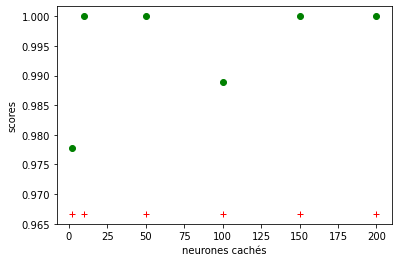

In [39]:
score_A,score_t=[],[]
for neurones in [2, 10, 50, 100, 150, 200]:
    clf= MLPClassifier(max_iter=5000,activation='relu',hidden_layer_sizes=(neurones), random_state=0)
    clf.fit(Xa,Ya)
    score_A.append(clf.score(Xa,Ya))
    score_t.append(clf.score(Xt,Yt))
    
plt.figure()
plt.xlabel('neurones cachés')
plt.ylabel('scores')
plt.plot([2, 10, 50, 100, 150, 200], score_A, 'go')
plt.plot([2, 10, 50, 100, 150, 200], score_t, 'r+')
plt.show()

<div class="alert alert-block alert-success">
A partir de 10 neurones le score est très élevé. </div>

## Question :

Avec la fonction d’activation ReLU pour les neurones des couches cachées et en conservant 10 neurones par couche cachée, faites varier le nombre de couches cachées entre 2 et 5. Que constatez-vous ? Il peut être nécessaire d’augmenter la valeur de `max_iter` pour que l’apprentissage se termine.

## Correction :


(10,)
(10, 10)
(10, 10, 10)
(10, 10, 10, 10)
(10, 10, 10, 10, 10)


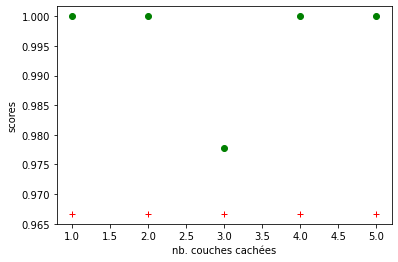

In [38]:
score_A,score_t=[],[]
for couche in [1, 2, 3, 4, 5]:
    clf= MLPClassifier(max_iter=5000,activation='relu',hidden_layer_sizes=(10,)*couche, random_state=0)
    print(clf.hidden_layer_sizes)
    clf.fit(Xa,Ya)
    score_A.append(clf.score(Xa,Ya))
    score_t.append(clf.score(Xt,Yt))
    
plt.figure()
plt.xlabel('nb. couches cachées')
plt.ylabel('scores')
plt.plot([1, 2, 3, 4, 5], score_A, 'go')
plt.plot([1, 2, 3, 4, 5], score_t, 'r+')
plt.show()

<div class="alert alert-block alert-success">
Le score est similaire. </div>